In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import random
from random import seed, randint, choice
import pandas as pd
from sklearn.model_selection import train_test_split

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

path_dir = '../../../../../../../project_rppg/Codes/subject_005/trial_001/video/'
dataPath = os.path.join(path_dir, '*.MOV')
files = glob.glob(dataPath)
list.sort(files)

2023-05-07 07:51:30.609603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from net_work_def import  MtlNetwork_head, MtlNetwork_body

In [3]:
def data_read(files, im_size=(200, 200)):
    
    data = []
    cap = cv2.VideoCapture(files[0])

    while cap.isOpened():
        ret, frame = cap.read()

        if ret == False:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        gray = gray[:, :, 1]
        gray =  gray[100:1000, 600:1400]
        gray = cv2.resize(gray, im_size)
        data.append(gray)
        
        cv2.imshow('frame', gray)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    data = np.array(data)

    return data

data = data_read(files, im_size = (100, 100))

In [12]:
def alignment_data(data, path_dir):

    CONST = 1599690864

    ppgtotal =  pd.read_csv(path_dir +'../empatica_e4/BVP.csv')
    EventMark = pd.read_csv(path_dir+'../empatica_e4/tags.csv')
    evmarknp =  EventMark.to_numpy()
    ppgnp =  ppgtotal.to_numpy()
    start_gap =  evmarknp[0] -   CONST
    
    end_point =  evmarknp[1] - evmarknp[0]
    
    ppgnp_align =  ppgnp[np.int(start_gap*64):np.int((start_gap+end_point)*64)]
    
    data_align = data[194 : 194 +np.int(end_point*30)+5] 
    ppgnp_align = np.reshape(ppgnp_align, [ppgnp_align.shape[0],1]) 

    return data_align, ppgnp_align

data_align, ppgnp_align = alignment_data(data, path_dir) 
print(data_align.shape, ppgnp_align.shape)

(10738, 100, 100) (22898, 1)


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use

In [16]:
class data_loader():
    def __init__(self, video, ppg= None, im_size = (100, 100), frame_cons = 40, bs = 1):
        self.video = video
        self.max_len = video.shape[0] - 200
        self.ppg =  ppg
        self.im_size = im_size
        self.frame_cons = frame_cons
        self.bs = bs
    
    def get_sup_samp(self, pos  = None, frame_gap = 1):
        
        if pos==None:
            pos = randint(0, self.max_len)
        img = np.transpose(self.video[pos:pos+self.frame_cons*frame_gap:frame_gap,:,:],[1,2,0])
        p_point = np.int(np.round(pos*64/30))
        ppg_gt = self.ppg[p_point: p_point+85*frame_gap: frame_gap, 0]
        ppg_gt = ppg_gt-np.min(ppg_gt)
        ppg_gt = (ppg_gt/np.max(ppg_gt))*2 -1
        img =  self.img_resize(img)
        return img, ppg_gt, pos
    
    def get_sup_data(self, bs = None):
        vs, gt = [], []
        if bs ==None: bs =self.bs
        for i in range(bs):
            frame_gap= 1 if random.random()>0.90 else 2
            sas, gtss, _ =  self.get_sup_samp(frame_gap=frame_gap)
            vs.append(sas); gt.append(gtss)
        return tf.cast(tf.stack(vs), tf.float32)/255.0, tf.cast(tf.stack(gt), tf.float32)
    
    def rand_frame_shuf(self, img):
        img = img.numpy()
        temp = np.arange(40)
        np.random.shuffle(temp)
        return img[:,:, temp]
    
    def frame_repeat(self, img):
        img = img.numpy()
        temp = randint(0,39)
        img[:,:,0:40] = img[:,:, temp:temp+1]
        return img
    
    def img_resize(self, img):
        return tf.image.resize(img, self.im_size)
    
    def rand_crop_tf(self, img):
        [temp1, temp2] =[randint(120,180),randint(120,180)]
        img = tf.image.random_crop(img, size=(temp1, temp2, 40)).numpy()
        return self.img_resize(img)
    
    def fps_halfing(self, pos):
        img, ppg_gt, _ = self.get_sup_samp(pos= pos, frame_gap= 2)
        return img, ppg_gt
    
    def img_shifted(self, pos, sv):
        img, _, _ =  self.get_sup_samp(pos = pos+sv)   
        return img
    
    def get_CL_data(self, pve = 1, nve = 5):
        vs = []
        query, _, pos = self.get_sup_samp()
        vs.append(query)
        pos_op = [0, 1]
        for _ in range(pve):
            dum = choice(pos_op)
            if dum ==0:
                pq = self.img_shifted(pos = pos, sv = 26)
                vs.append(pq)
            elif dum ==1:
                pq = self.rand_crop_tf(query)
                vs.append(pq)
        
        neg_op = [0, 1, 2, 3]
        for _ in range(nve):
            dum = choice(neg_op)
            if dum==0:
                nq = self.img_shifted(pos = pos, sv = 13)
                vs.append(nq)
            elif dum==1:
                nq = self.frame_repeat(query)
                vs.append(nq)
            elif dum==2:
                nq = self.rand_frame_shuf(query)
                vs.append(nq)
            elif dum==3:
                nq, _ = self.fps_halfing(pos = pos)
                vs.append(nq)
                
        return  tf.cast(tf.stack(vs), tf.float32)/255.0

In [17]:
def RootMeanSquareLoss(x,y):
    
    # pdb.set_trace()  
    loss = tf.keras.losses.MSE(y_true = y, y_pred =x)  # initial one
    #return tf.reduce_mean(loss)  # some other shape similarity
     
    loss2 = tf.reduce_mean((tf.math.abs(tf.math.sign(y))-tf.math.sign(tf.math.multiply(x,y))),axis = -1)
    # print(loss2.shape)
    
    # print(tf.reduce_mean(loss), tf.reduce_mean(loss2))
    return loss + 0.5*loss2

In [18]:
def run_optimization(neural_net, x,y, learning_rate = 1e-3):   
    optimizer  = tf.optimizers.SGD(learning_rate*2)
    optimizer1 = tf.optimizers.SGD(learning_rate/2)
    with tf.GradientTape() as g:
        pred =  neural_net(x, training = True)
        loss =  RootMeanSquareLoss(y, pred)  # change for mtl
    
    convtrain_variables =  neural_net.layers[0].trainable_variables
    fcntrain_variables =  neural_net.layers[1].trainable_variables
    
    # trainable_variables =  neural_net.trainable_variables[:-6] 
    # also there are other ways to update the gradient it would give the same results
    # trainable_var is a list, select your intended layers: use append
    
    gradients =  g.gradient(loss, convtrain_variables+fcntrain_variables) 
    # gradients and trainable variables are list
    
    grads1 =  gradients[:len(convtrain_variables)]
    grads2 = gradients[len(convtrain_variables):]
    
    optimizer.apply_gradients(zip(grads1, convtrain_variables))
    optimizer1.apply_gradients(zip(grads2, fcntrain_variables))

In [9]:
from net_work_def import  MtlNetwork_head, MtlNetwork_body

def netw_fcnal(num_classes = 85):
    
    mtl_body =  MtlNetwork_body()
    head1 =  MtlNetwork_head(num_classes)
    head2 = MtlNetwork_head(num_classes)
    
    neural_net1 =  tf.keras.Sequential([mtl_body, head1])
    neural_net2 =  tf.keras.Sequential([mtl_body, head2])
    return neural_net1, neural_net2

In [34]:
train_loss =[]
val_loss = []
steps = 5000
def train_nn(neural_net1, neural_net2, train_data):
 
        
    for step in range(steps): 
        # pdb.set_trace()
        
        # body + Head1 training
        
        
        batch_x, batch_y = train_data.get_sup_data()
        run_optimization(neural_net1, batch_x, batch_y)
        
        # run_optimization(neural_net2, batch_x1, batch_y1)
        
        
        if step % (100*2) == 0:
            pred = neural_net1(batch_x, training=True)
            # pdb.set_trace()
            loss = RootMeanSquareLoss(batch_y, pred)
            train_loss.append(tf.reduce_mean(loss))
            # Val_loss(neural_net1, teX[0:16], teY[0:16])
            print("step: %i, loss: %f v" % (step, tf.reduce_mean(loss)))

In [35]:
samp_load =  data_loader(video=data_align, ppg = ppgnp_align, bs = 8)
neural_net1, neural_net2 =  netw_fcnal()
train_nn(neural_net1, neural_net2, train_data = samp_load)

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


step: 0, loss: 0.797302 v
step: 200, loss: 0.673669 v
step: 400, loss: 0.678712 v
step: 600, loss: 0.676850 v
step: 800, loss: 0.699512 v
step: 1000, loss: 0.634119 v
step: 1200, loss: 0.680602 v
step: 1400, loss: 0.671733 v
step: 1600, loss: 0.655772 v


KeyboardInterrupt: 

6870
(10738, 100, 100)
6890
(10738, 100, 100)
6910
(10738, 100, 100)


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


6930
(10738, 100, 100)
6950
(10738, 100, 100)
6970
(10738, 100, 100)
6990
(10738, 100, 100)
7010
(10738, 100, 100)
7030
(10738, 100, 100)


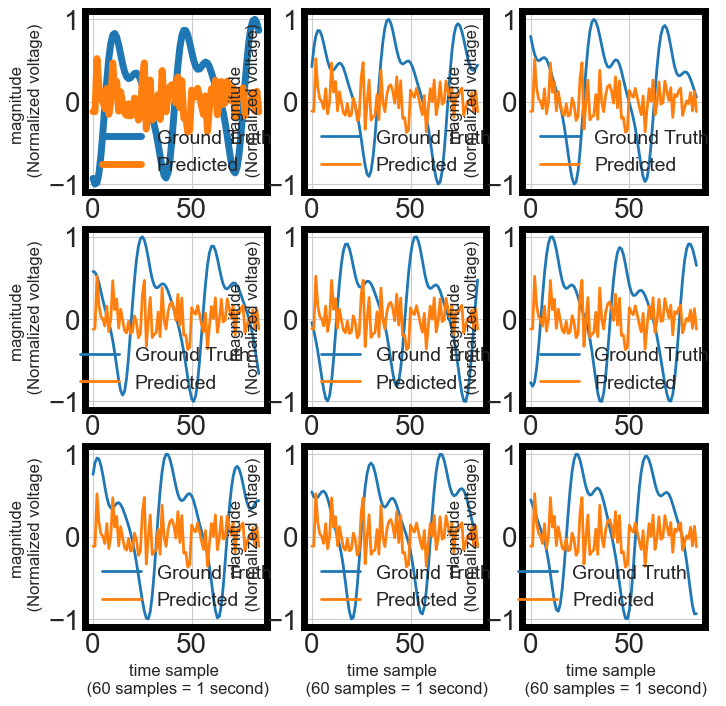

In [ ]:
i = 5000

fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for j in range( 1, columns*rows +1 ):
    
    i =randint( 50, 5100)
    i=  6850+j*20
    print(i)
    print(data_align.shape)
    tX = np.reshape(data_align[i:i+40,:,:], [40,100,100])
    tX = np.array(tX, dtype= np.float64)
    tX = np.moveaxis(tX, 0,-1) # very important line in axis changeing 
    
    p_point = np.int(np.round(i*64/30))
    
    gt = pulR[p_point: p_point+85, 0]

    gt = (gt-gt.min())/(gt.max()-gt.min())
    
    # i  = 5+j +j
    # tX = teX1[i]    
    # gt = 0.5*(teY1[i]+1)    
    # tX = teX[i]    
    # gt = 0.5*(teY[i]+1)
    
    fig.add_subplot(rows, columns, j)
    tX1 = np.reshape(tX, [-1, 100,100,40])
    plt.plot(gt*2-1)
    
    tX1 = (tX1 - tX1.min())/(tX1.max() - tX1.min())
    

    # predd = neural_net(trX1) 
    
    
    predd = neural_net1(tX1) 
    plt.plot(predd[0])

    plt.legend(["Ground Truth", "Predicted"])
    plt.xlabel('time sample \n (60 samples = 1 second)', fontsize =12)
    plt.ylabel('magnitude \n (Normalized voltage)', fontsize = 12)
    from matplotlib import rcParams
    rcParams['lines.linewidth'] = 2
    rcParams['lines.color'] = 'r'
   
# plt.savefig('sub4goodres.eps', format = 'eps', dpi= 600)
plt.show()

Model: "mtl_network_body_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_bn_relu_14 (ConvBNRelu  multiple                 11680     
 )                                                               
                                                                 
 conv_bn_relu_15 (ConvBNRelu  multiple                 18752     
 )                                                               
                                                                 
 max_pooling2d_4 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv_bn_relu_16 (ConvBNRelu  multiple                 37184     
 )                                                               
                                                                 
 conv_bn_relu_17 (ConvBNRelu  multiple          

Text(0.5, 1.0, 'PPG magnitude changes')

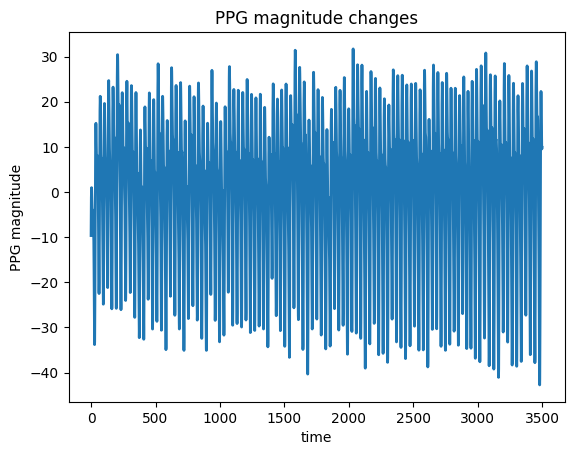

In [ ]:
neural_net1.layers[0].summary()
plt.plot(pulR[500:4000])
plt.xlabel('time')
plt.ylabel('PPG magnitude')
plt.title("PPG magnitude changes")

In [ ]:
#%% Signal Reconstruction

divVec = np.ones([85])
divVec1 = np.zeros([85]) 

gtV = np.zeros([85])

recPPG = np.zeros([85])

for j in range(1):
    
    olap = 40
    i = 4090 +j*olap
    print(i)
    tX = np.reshape(data_align[i:i+40:1,:,:], [40,100,100])
    tX = np.array(tX, dtype= np.float64)
    tX = np.moveaxis(tX, 0,-1) # very important line in axis changeing 
     
    p_point = np.int(np.round(i*64/30))
    
    gt = pulR[p_point: p_point+85:1, 0]
    gt = (gt-gt.min())/(gt.max()-gt.min())
    
    # i  = 5+j +j
    # tX = teX1[i]    
    # gt = 0.5*(teY1[i]+1)    
    # tX = teX[i]    
    # gt = 0.5*(teY[i]+1)    

    tX1 = np.reshape(tX, [-1, 100,100,40])

    
    tX1 = (tX1 - tX1.min())/(tX1.max() - tX1.min())
    
    olap =  np.int(olap*64/30)
    
    # predd = neural_net(trX1) 
    predd = neural_net1(tX1) 
    
    recPPG[-85:] = recPPG[-85:] + predd
    
    recPPG = np.concatenate((recPPG, np.zeros([olap])))
    
    
    gtV[-85:] = gtV[-85:] + np.squeeze(gt*2-1)
    gtV = np.concatenate((gtV, np.zeros([olap])))
    
    
    divVec1[-85:] = divVec1[-85:]+divVec
    divVec1 = np.concatenate((divVec1, np.zeros([olap])))   

4090


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the releas

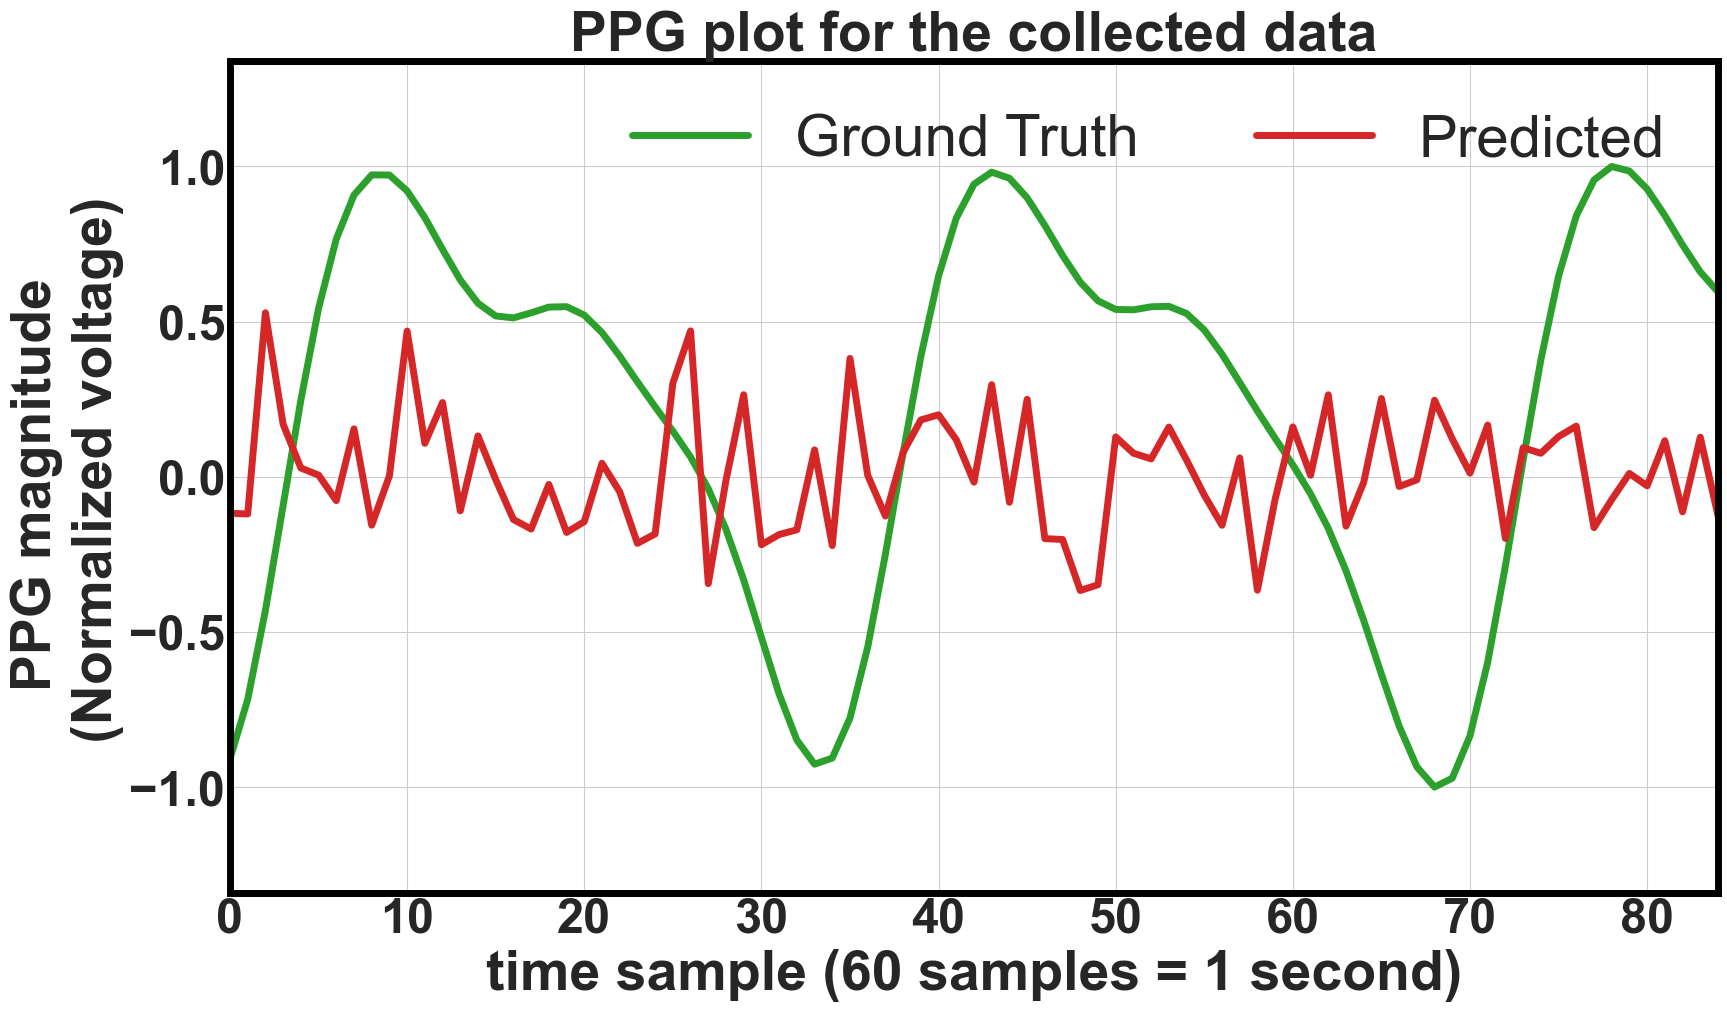

In [ ]:
fig = plt.figure(figsize=(19.20,10.80))
plt.plot(gtV[:-85], 'C2')
plt.plot(recPPG[:-85], 'C3')
plt.legend(["Ground Truth", "Predicted"], fontsize = 42, loc = "upper right", ncol = 2)
plt.xlabel('time sample (60 samples = 1 second)', fontsize =40, fontweight = 'bold')
plt.ylabel('PPG magnitude \n (Normalized voltage)', fontsize = 40, fontweight= 'bold')

plt.title("PPG plot for the collected data", fontsize = 40, fontweight = 'bold')

plt.margins(x =0, y =0.17)
# from matplotlib import rcParams
# rcParams['lines.linewidth'] = 4
# rcParams['lines.color'] = 'r'
plt.xticks(fontsize = 35, fontweight = 'bold')
plt.yticks(fontsize = 35, fontweight =  'bold')

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = 'r'
mpl.rcParams['font.weight'] = 200
plt.style.use('seaborn-whitegrid')

mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.linewidth'] = 5
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['legend.fontsize'] = 14

# plt.savefig('cd_sample_res.eps', format = 'eps', dpi= 500)

plt.show() 